In [2]:
import yfinance as yf
import pandas as pd

# Define stock ticker
ticker = "AAPL"

# Fetch historical data
data = yf.download(ticker, start="2024-01-01", end="2025-02-07", interval="1d")

# Fetch real-time data (latest trading day)
real_time_data = yf.Ticker(ticker).history(period="1d")

print(data.tail())  # Print last few rows of historical data
print(real_time_data)  # Print real-time data


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2025-01-31  236.000000  247.190002  233.440002  247.190002  101075100
2025-02-03  228.009995  231.830002  225.699997  229.990005   73063300
2025-02-04  232.800003  233.130005  226.649994  227.250000   45067300
2025-02-05  232.470001  232.669998  228.270004  228.529999   39620300
2025-02-06  231.270004  233.800003  230.425003  231.339996   13567135
                                 Open        High         Low       Close  \
Date                                                                        
2025-02-06 00:00:00-05:00  231.339996  233.800003  230.425003  231.270004   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-02-06 00:00:00-05:00  13567135        0.0           0.0  


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' price as feature
data = data[['Close']]

# Normalize data (LSTM works best with normalized inputs)
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=['Close'])
print(data_scaled.head())  # Print first few rows


               Close
Date                
2024-01-02  0.214869
2024-01-03  0.200250
2024-01-04  0.175639
2024-01-05  0.167961
2024-01-08  0.214028


In [4]:
import torch

# Convert data to PyTorch tensor
def create_sequences(data, lookback=50):
    sequences, targets = [], []
    for i in range(len(data) - lookback):
        sequences.append(data[i:i+lookback])  # Last 'lookback' days as input
        targets.append(data[i+lookback])  # Next day's price as target
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Use last 50 days to predict next day
lookback = 50
X, y = create_sequences(data_scaled.values, lookback)

# Split into training (80%) and testing (20%) sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")


Training Samples: torch.Size([180, 50, 1]), Test Samples: torch.Size([46, 50, 1])


/tmp/ipykernel_25024/165011438.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


In [5]:
import torch.nn as nn

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value (next-day price)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # Take the last timestep output
        return self.fc(last_output)

# Initialize Model
model = LSTMModel()
print(model)



LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [6]:
import torch.optim as optim

# Define Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 0.1015
Epoch 20/50, Loss: 0.0566
Epoch 30/50, Loss: 0.0463
Epoch 40/50, Loss: 0.0338
Epoch 50/50, Loss: 0.0192


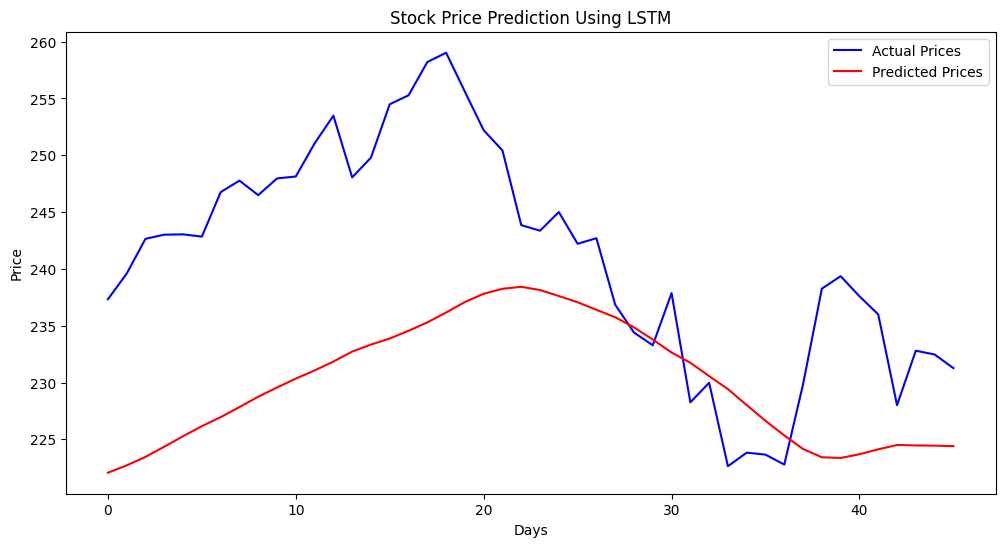

In [7]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Convert back to original price scale
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(test_predictions, label="Predicted Prices", color="red")
plt.title("Stock Price Prediction Using LSTM")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()



[*********************100%***********************]  1 of 1 completed


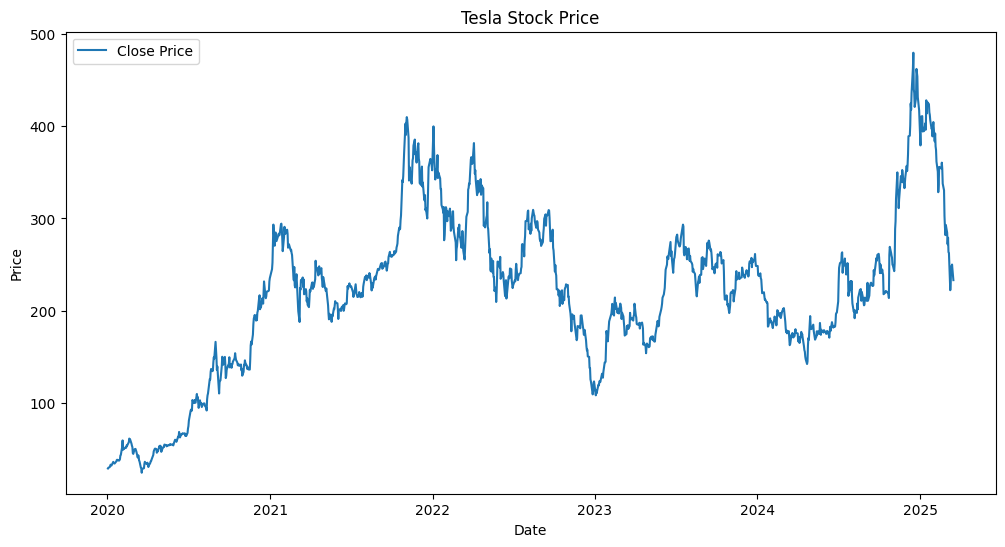

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

data = yf.download('TSLA', start='2020-01-01', end='2025-03-18', auto_adjust=False)

data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Close'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

In [7]:
def create_dataset(dataset, lookback=60):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        X.append(dataset[i:(i+lookback), 0])
        y.append(dataset[i+lookback, 0])
    return np.array(X), np.array(y)

dataset = data.values
lookback = 60

X, y = create_dataset(dataset, lookback)

In [8]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

In [16]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        # 在測試集上評估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 10/100, Loss: 0.1146, Test Loss: 0.1604
Epoch 20/100, Loss: 0.0468, Test Loss: 0.0319
Epoch 30/100, Loss: 0.0266, Test Loss: 0.0523
Epoch 40/100, Loss: 0.0205, Test Loss: 0.0309
Epoch 50/100, Loss: 0.0184, Test Loss: 0.0254
Epoch 60/100, Loss: 0.0142, Test Loss: 0.0202
Epoch 70/100, Loss: 0.0074, Test Loss: 0.0066
Epoch 80/100, Loss: 0.0049, Test Loss: 0.0206
Epoch 90/100, Loss: 0.0034, Test Loss: 0.0047
Epoch 100/100, Loss: 0.0028, Test Loss: 0.0043


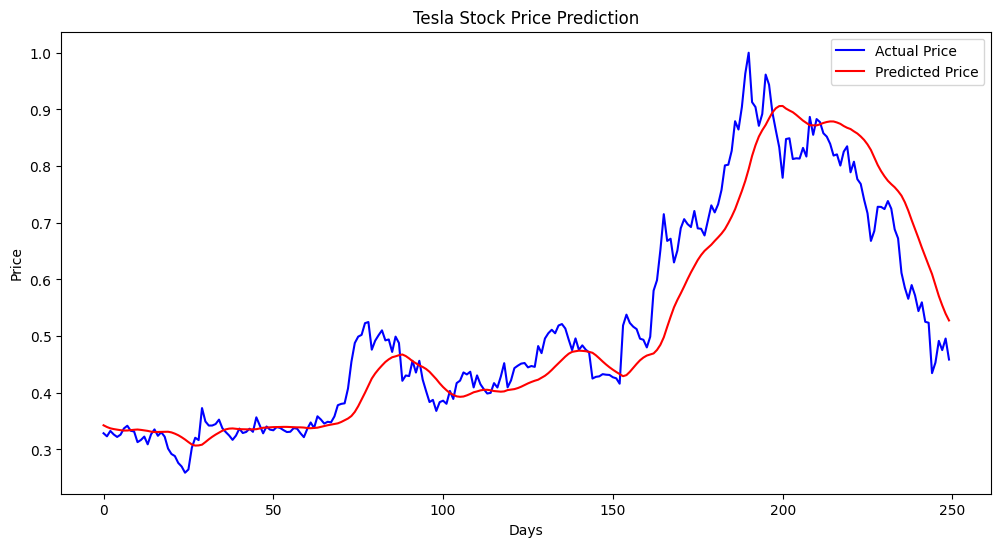

In [17]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='red')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 0.05
Test RMSE: 0.07


## table Baselines 3

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])  # 確保 Date 列為 datetime 類型
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Date', inplace=True)

# 數據預處理
data['Open'] = data['Open'].astype('float32')
data['High'] = data['High'].astype('float32')
data['Low'] = data['Low'].astype('float32')
data['Close'] = data['Close'].astype('float32')
data['Volume'] = data['Volume'].astype('float32')

# 定義交易環境
class TradingEnv(gym.Env):
    """自訂的交易環境，用於強化學習模型訓練，代理觀察過去 15 天的數據"""

    def __init__(self, data, window_size=15, cash=10000, commission=0.001):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index()
        self.cash = cash  # 初始現金
        self.initial_cash = cash  # 紀錄初始現金
        self.commission = commission  # 交易手續費
        self.window_size = window_size  # 觀察窗口大小
        self.current_step = self.window_size  # 開始位置

        # 定義觀測空間和行動空間
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.window_size, 5), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # 0: 持有, 1: 買入, 2: 賣出

        # 初始化帳戶資訊
        self.position = 0  # 持有的股票數量
        self.net_worth = self.cash  # 資產淨值
        self.prev_net_worth = self.cash  # 前一步的資產淨值

        # 紀錄交易訊號
        self.trades = []

    def _get_obs(self):
        """獲取當前的觀測值"""
        obs = self.data.loc[self.current_step - self.window_size:self.current_step - 1, ['Open', 'High', 'Low', 'Close', 'Volume']].values
        return obs

    def reset(self, *, seed=None, options=None):
        """重置環境到初始狀態"""
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.position = 0
        self.cash = self.initial_cash
        self.net_worth = self.cash
        self.prev_net_worth = self.cash
        self.trades = []  # 重置交易紀錄
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        """執行一個行動，並返回新的狀態和獎勵"""
        current_price = self.data.loc[self.current_step, 'Close']

        # 記錄交易訊號
        date = self.data.loc[self.current_step, 'Date']
        self.trades.append({'Date': date, 'Action': action})

        # 計算交易手續費
        commission = 0

        if action == 1:  # 買入
            # 計算可買入的最大股數
            max_shares = int(self.cash / (current_price * (1 + self.commission)))
            if max_shares > 0:
                # 更新帳戶餘額和持倉
                cost = max_shares * current_price * (1 + self.commission)
                self.cash -= cost
                self.position += max_shares
                commission = cost * self.commission
        elif action == 2:  # 賣出
            if self.position > 0:
                # 更新帳戶餘額和持倉
                revenue = self.position * current_price * (1 - self.commission)
                self.cash += revenue
                commission = self.position * current_price * self.commission
                self.position = 0
        # action == 0 表示持有，不執行任何操作

        self.current_step += 1

        # 更新資產淨值
        self.net_worth = self.cash + self.position * current_price

        # 計算獎勵
        reward = float(self.net_worth - self.prev_net_worth - commission)
        self.prev_net_worth = self.net_worth

        # 判斷是否終止
        if self.current_step >= len(self.data):
            terminated = True
        else:
            terminated = False
        truncated = False

        obs = self._get_obs()
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        """渲染環境（此處未實作）"""
        pass

# 定義自訂的特徵提取器
class CustomLSTMFeatureExtractor(BaseFeaturesExtractor):
    """
    自訂的特徵提取器，使用 LSTM 處理時間序列數據
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 128):
        super(CustomLSTMFeatureExtractor, self).__init__(observation_space, features_dim)
        self.lstm = nn.LSTM(input_size=5, hidden_size=features_dim, batch_first=True)

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # observations shape: (batch_size, window_size, 5)
        lstm_output, (h_n, c_n) = self.lstm(observations)
        # 我們取最後一個時間步的輸出作為特徵
        return h_n[-1]

# 創建環境實例
env = TradingEnv(data)

# 檢查環境
env_checker.check_env(env)

# 包裝環境
env = DummyVecEnv([lambda: env])

# 定義政策網絡
policy_kwargs = dict(
    features_extractor_class=CustomLSTMFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

# 訓練模型
model = PPO('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)

# 測試模型並收集交易訊號
env.envs[0].reset()
for i in range(env.envs[0].window_size, len(data)):
    obs = env.envs[0]._get_obs()
    obs = obs[np.newaxis, :]  # 添加 batch 維度
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, truncated, info = env.envs[0].step(action[0])
    if dones:
        break

# 從環境中獲取交易紀錄
trades = pd.DataFrame(env.envs[0].trades)

# 將交易紀錄與原始數據合併
# Flatten the multi-level columns if needed
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Merge the data with trades on the 'Date' column
merged_data = pd.merge(data, trades, on='Date', how='left')
merged_data['Action'].fillna(0, inplace=True)

# 確保 Date 列為 datetime 類型
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# 在 Backtrader 中顯示買賣點
class RLStrategy(bt.Strategy):
    """自訂的策略，用於在圖表上顯示買賣點"""

    def __init__(self):
        self.dataclose = self.datas[0].close

    def next(self):
        # 根據交易紀錄執行買賣
        idx = len(self) - 1  # 當前索引
        action = merged_data.loc[idx, 'Action']
        if action == 1 and self.position.size == 0:
            # 買入
            self.buy(size=100)
        elif action == 2 and self.position.size > 0:
            # 賣出
            self.sell(size=self.position.size)

# 設置 Backtrader
cerebro = bt.Cerebro()
# 在添加數據時，指定 datetime 列
data_bt = bt.feeds.PandasData(
    dataname=merged_data,
    datetime='Date',
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    openinterest=-1,
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data_bt)
cerebro.addstrategy(RLStrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.001)

print('初始資金: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('最終資金: %.2f' % cerebro.broker.getvalue())

# 繪製圖表
%matplotlib inline
cerebro.plot(iplot=True, volume=False)

[*********************100%***********************]  1 of 1 completed
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element 

Using cuda device


/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/t

-----------------------------
| time/              |      |
|    fps             | 248  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------


/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/t

-------------------------------------------
| time/                   |               |
|    fps                  | 241           |
|    iterations           | 2             |
|    time_elapsed         | 16            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00075736595 |
|    clip_fraction        | 0.0165        |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.09         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.62e+04      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00137      |
|    value_loss           | 1.4e+05       |
-------------------------------------------


/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/

-----------------------------------------
| time/                   |             |
|    fps                  | 239         |
|    iterations           | 3           |
|    time_elapsed         | 25          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.006870918 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 9.83e+04    |
|    n_updates            | 20          |
|    policy_gradient_loss | 0.00022     |
|    value_loss           | 1.65e+05    |
-----------------------------------------


/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/

-----------------------------------------
| time/                   |             |
|    fps                  | 236         |
|    iterations           | 4           |
|    time_elapsed         | 34          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.003183648 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 7.1e+04     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0016     |
|    value_loss           | 1.69e+05    |
-----------------------------------------


/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)


-----------------------------------------
| time/                   |             |
|    fps                  | 234         |
|    iterations           | 5           |
|    time_elapsed         | 43          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.013936806 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 7.61e+04    |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00188    |
|    value_loss           | 1.47e+05    |
-----------------------------------------


/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/tmp/ipykernel_6218/4280547016.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(self.net_worth - self.prev_net_worth - commission)
/tmp/ipykernel_6218/4280547016.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))
/t

ValueError: You are trying to merge on datetime64[ns] and object columns for key 'Date'. If you wish to proceed you should use pd.concat